# Multimodal Search

## Dataset Import + Embeddings computation

In [2]:
# https://huggingface.co/datasets/detection-datasets/coco
import torch
from datasets import load_from_disk
from datasets import load_dataset

from transformers import AutoFeatureExtractor, CvtForImageClassification
from transformers import ViTImageProcessor, ViTModel
device = "mps"

dataset = load_dataset("detection-datasets/coco")
# dataset = load_dataset("beans")

# https://huggingface.co/blog/image-similarity

from transformers import AutoFeatureExtractor, AutoModel

# model_ckpt = "nateraw/vit-base-beans"
# extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
# model = AutoModel.from_pretrained(model_ckpt)

# extractor = AutoFeatureExtractor.from_pretrained('microsoft/cvt-21-384')
# model = AutoModel.from_pretrained('microsoft/cvt-21-384')
# device = "mps"
# model.to(device)
# print("model downloaded")

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
extractor = AutoFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)
print("model downloaded")



/opt/homebrew/Caskroom/miniforge/base/envs/multimodal-search/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (/Users/baptiste/.cache/huggingface/datasets/detection-datasets___parquet/detection-datasets--coco-64ef6d5414f6b8df/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00,  8.18it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/multimodal-search/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model downloaded


In [3]:
num_samples = 100
seed = 42
dataset = load_dataset("detection-datasets/coco")
dataset = dataset["train"]

# dataset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

dataset.__len__()

Found cached dataset parquet (/Users/baptiste/.cache/huggingface/datasets/detection-datasets___parquet/detection-datasets--coco-64ef6d5414f6b8df/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 10.68it/s]


117266

In [6]:
import torchvision.transforms as T


model_input_size = 224
# Data transformation chain.
transformation_chain = T.Compose(
    [
        # use https://huggingface.co/microsoft/cvt-21-384 
        T.Resize(model_input_size),
        T.CenterCrop(model_input_size),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
        
    ]
)

In [20]:
import os
import shutil


def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # do not forget to convert to RGB
        images = torch.stack([transformation_chain(image.convert('RGB')) for image in images])
        images = images.to(device)

        with torch.no_grad():

            embeddings = model(images)
            # 0 because [CLS] token that represent the whole class https://github.com/huggingface/transformers/issues/16984
            embeddings = embeddings.last_hidden_state[:, 0]
            embeddings = embeddings.cpu()

            # print(embeddings.shape)
            return {"embeddings": embeddings}

    return pp

# if memory is an issue, you can use a smaller batch size
batch_size = 32
extract_fn = extract_embeddings(model.to(device))

save_path = "./data/coco_embeddings"


# if coco embedding dataset is not on disk, do map
# if not os.path.exists(save_path):
dataset_emb = dataset.map(extract_fn, batched=True, batch_size=batch_size)
if os.path.exists(save_path):
    print("removing old dataset")
    shutil.rmtree(save_path)
    
dataset_emb.save_to_disk(save_path)
print("dataset saved")

Parameter 'function'=<function extract_embeddings.<locals>.pp at 0x1316af820> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.
Map:   1%|          | 736/117266 [00:10<28:18, 68.63 examples/s]

In [4]:

# https://huggingface.co/course/chapter5/6?fw=pt#using-faiss-for-efficient-similarity-search
save_path = "./data/coco_embeddings"
dataset_emb = load_from_disk(save_path)
print("dataset loaded")
# print(dataset_emb["embeddings"])
print(dataset_emb.__len__())

dataset_emb.add_faiss_index(column="embeddings")

dataset loaded
117266


100%|██████████| 118/118 [00:00<00:00, 451.21it/s]


Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects', 'embeddings'],
    num_rows: 117266
})

torch.Size([1, 768])


torch.Size([768])

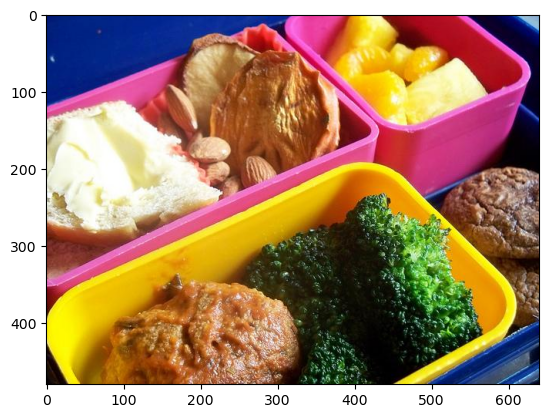

In [24]:
def get_embeddings(image):
    image = transformation_chain(image.convert('RGB'))
    image = torch.stack([image])
    image = image.to(device)
    with torch.no_grad():
        embeddings = model(image)
        embeddings = embeddings.last_hidden_state[:, 0].cpu()
        print(embeddings.shape)
        embeddings = embeddings.squeeze(0)
        return embeddings

image = dataset_emb[0]["image"]

# print image
import matplotlib.pyplot as plt
plt.imshow(image)

question_embedding = get_embeddings(image)
question_embedding.shape

torch.Size([768])


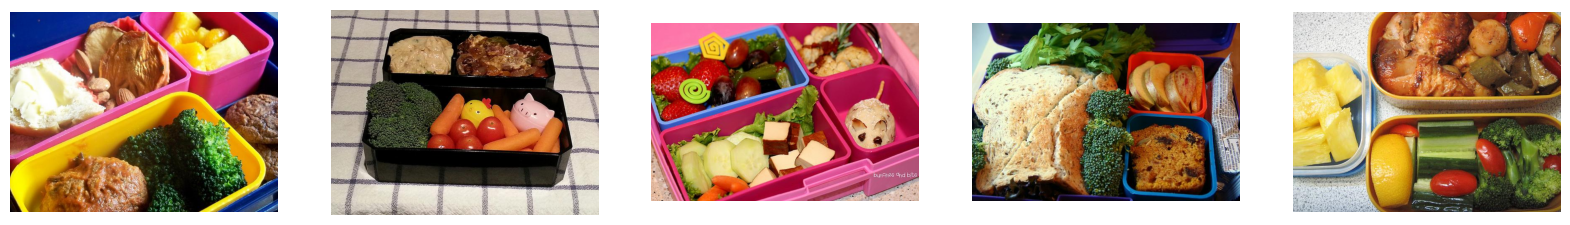

In [28]:
import matplotlib.pyplot as plt


print(torch.tensor(dataset_emb["embeddings"][32]).shape)

def get_nearest_examples(embedding, k=5):
    return dataset_emb.get_nearest_examples("embeddings", embedding.numpy(), k=k)

scores, samples = get_nearest_examples(question_embedding)

def plot_nearest_samples(samples):

    sample_images = samples["image"]

    fig, axs = plt.subplots(1, 5, figsize=(20, 20))
    for i, ax in enumerate(axs):
        ax.imshow(sample_images[i])
        ax.axis("off")
    plt.show()

plot_nearest_samples(samples)

## Debug (for internal testing)

In [15]:
# get number of layers in the model


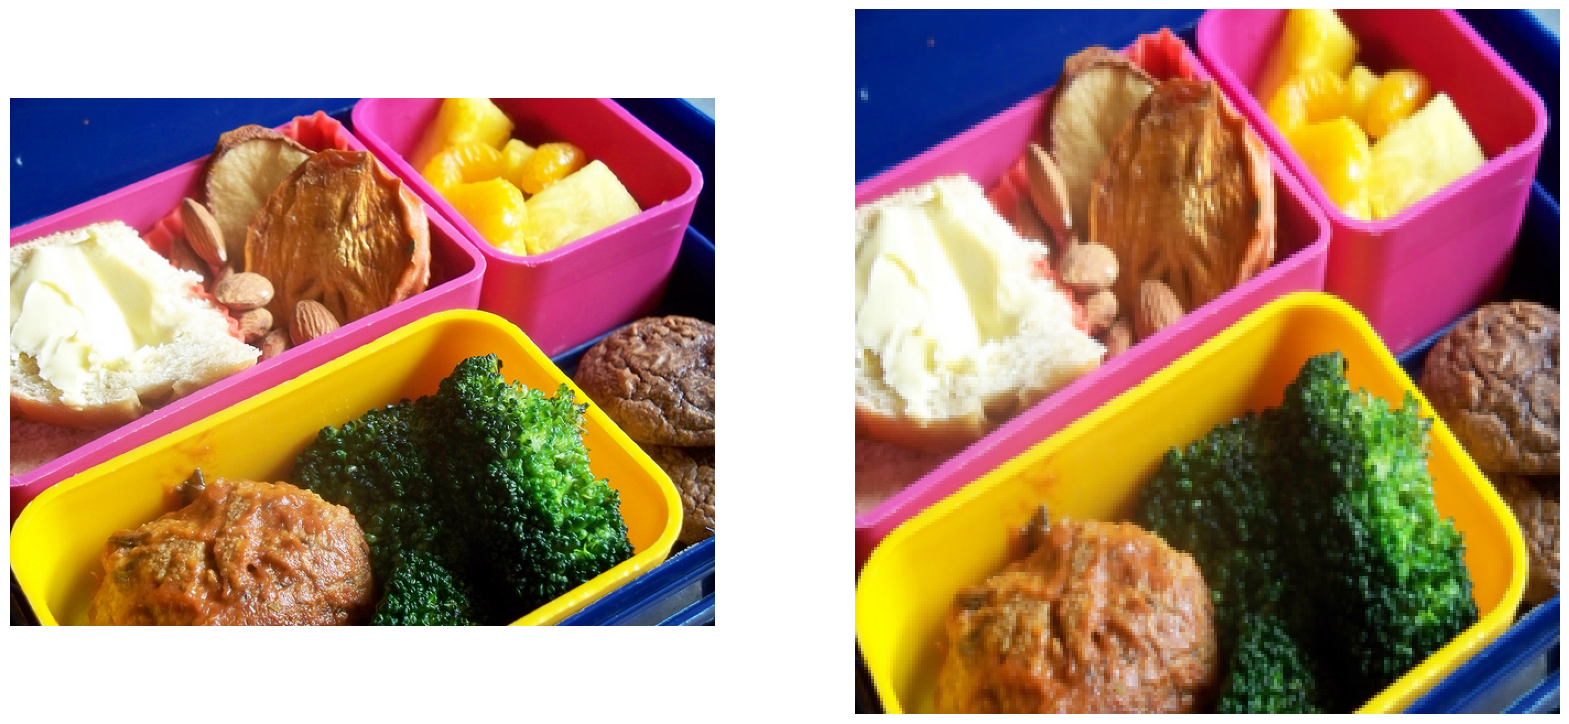

In [9]:
image = dataset["train"][0]["image"]

# print image
import matplotlib.pyplot as plt
# plt.imshow(image)

small_image =  T.Resize((224, 224))(image)

# plot both images
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(image)
axs[0].axis("off")
axs[1].imshow(small_image)
axs[1].axis("off")
plt.show()



In [83]:
from transformers import ViTImageProcessor, ViTModel


processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
model.to(device)

# Data transformation chain.
transformation_chain = T.Compose(
    [
        # use https://huggingface.co/microsoft/cvt-21-384 
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
        
    ]
)
# model_ckpt = "nateraw/vit-base-beans"
# extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
# model = AutoModel.from_pretrained(model_ckpt)

image = dataset["train"][0]["image"]
images = torch.stack([transformation_chain(image.convert('RGB')) for image in [image, image]])
images = images.to(device)
model.to(device)
model(images).last_hidden_state.shape

# ([2, 197, 768])

torch.Size([2, 197, 768])

In [70]:
from transformers import AutoImageProcessor, ViTModel

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
# encoder = model.encoder
# from sentence_transformers import SentenceTransformer

from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')


# model = SentenceTransformer('clip-ViT-B-32')

image = dataset["train"][0]["image"]

# https://huggingface.co/blog/vision_language_pretraining
# really interesting blog post

# Data transformation chain.
transformation_chain_2 = T.Compose(
    [
        # use https://huggingface.co/microsoft/cvt-21-384 
        T.Resize(768),
        T.CenterCrop(768),
        T.ToTensor(),
        # T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
        
    ]
)

# https://www.activeloop.ai/resources/generate-image-embeddings-using-a-pre-trained-cnn-and-store-them-in-hub/

image = transformation_chain_2(image.convert('RGB'))
# image = torch.stack([image])
image = image.to(device)
model.to(device)
print(image.shape)
# encode the image

import torchvision.models as models
model = models.resnet18(pretrained=True)
layer = model._modules.get('avgpool')

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(img):
    # 1. Load the image with Pillow library
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding
image = dataset["train"][0]["image"]
print(image)
get_vector(image)

# image_features = feature_extractor(image)

# image_features["pixel_values"][0].shape

/opt/homebrew/Caskroom/miniforge/base/envs/multimodal-search/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


torch.Size([3, 768, 768])
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x2AA76FE50>


/opt/homebrew/Caskroom/miniforge/base/envs/multimodal-search/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/multimodal-search/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: output with shape [512] doesn't match the broadcast shape [1, 512, 1, 512]

## Pix2Pix

  0%|          | 0/10 [00:00<?, ?it/s]/opt/homebrew/Caskroom/miniforge/base/envs/multimodal-search/lib/python3.9/site-packages/diffusers/schedulers/scheduling_euler_ancestral_discrete.py:164: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1675740439190/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  step_index = (self.timesteps == timestep).nonzero().item()
100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


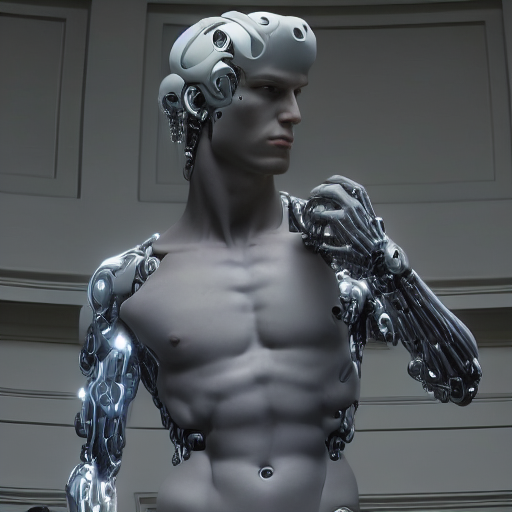

In [27]:
# https://huggingface.co/timbrooks/instruct-pix2pix

import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("mps")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

url = "https://raw.githubusercontent.com/timothybrooks/instruct-pix2pix/main/imgs/example.jpg"
def download_image(url):
    image = PIL.Image.open(requests.get(url, stream=True).raw)
    image = PIL.ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    return image
image = download_image(url)

prompt = "turn him into cyborg"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]



torch.Size([1, 768])


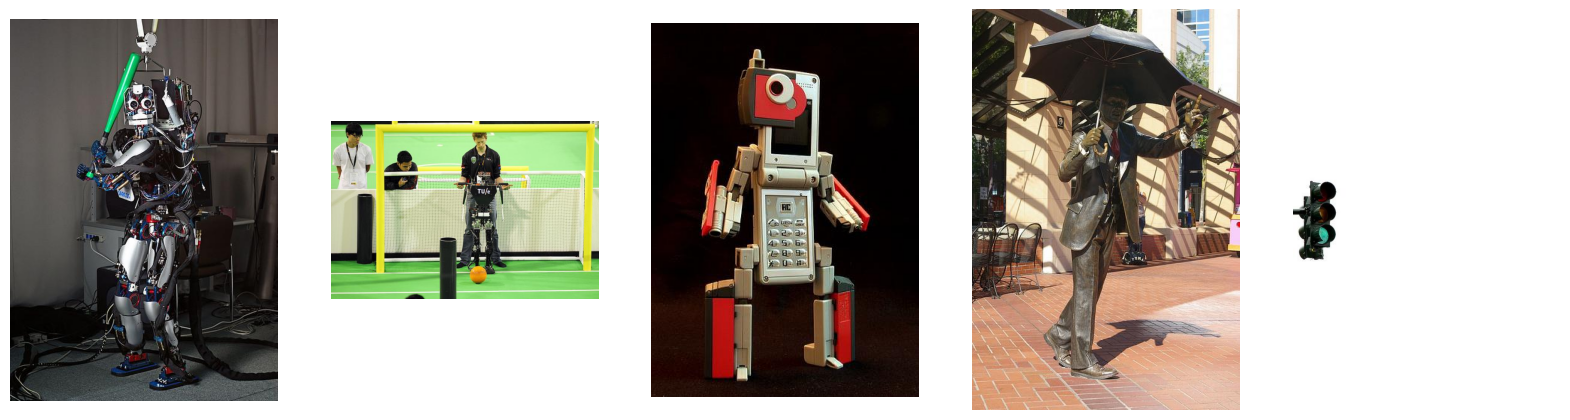

In [32]:
pix2pix_embedding = get_embeddings(images[0])

pix2pix_scores, pix2pix_samples  = get_nearest_examples(pix2pix_embedding)

plot_nearest_samples(pix2pix_samples)

In [ ]:
# todo 
# create fully working pipeline (upload image + text and get nearest examples)
# create a web app (input image + text and get modified image, nearest examples modified image, nearest examples original image)
# add legend and description webapp  + upload to huggingface spaces?

## UI

In [ ]:
import gradio as gr

def image_classifier(inp):
    return {'cat': 0.3, 'dog': 0.7}

# 3 images return the modified image, the most similiar to the input image, and the most similiar to the modified images
# todo make this return n most similiar images
demo = gr.Interface(fn=image_classifier, inputs=["image", "text"], outputs=["image", "image", "image"])
demo.launch()

/opt/homebrew/Caskroom/miniforge/base/envs/multimodal-search/lib/python3.9/site-packages/gradio/utils.py:951: UserWarning: Expected 1 arguments for function <function image_classifier at 0x2caaf4ee0>, received 2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/multimodal-search/lib/python3.9/site-packages/gradio/utils.py:959: UserWarning: Expected maximum 1 arguments for function <function image_classifier at 0x2caaf4ee0>, received 2.
  warnings.warn(


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
